## Introduction

This notebook is for plotting the comparison among the PC1, Approximated PC1-pattern and the Pearson matrix on those experiments which shows a lower similar_rate then average, such as:

* k562, chromosome 22,resolution 1000000
* hmec, chromosome 9, resolution 1000000
* nhek, chromosome 9, resolution 1000000
* kbm7, chromosome 4, resolution 1000000
* hmec, chromosome 4, resolution 1000000

We found that in some cases the mean of the GC-content at the positive sign entries versus the negative sign entries are very similar, and hence it leads to a very low similar_rate (e.g. K562, chromosome 22,resolution 1000000); In other cases we attempt to figure out the difference between the PC1 and the Approximated PC1-pattern. The "PC1" we referred in this notebook included the juicer_tools created PC1 (We regard it as the ground truth of the Chromosome compartment analysis) and the Scikit-learn calculated PC1.

In [90]:
import numpy as np
import pandas as pd
from hicpap import paptools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [91]:
# Please specify the path where you store the data for the `code_the_paper` 
# https://github.com/ZhiRongDev/HiCPAP/blob/main/docs/code_for_paper.rst
data_store="/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpap/data_store"

In [92]:
# Please specify the cell_line you would like to check   
cell_line = "k562" # The cell line used in Rao 2014's experiments.
resolution = 1000000
chrom = "22"
ref="hg19" # hg19 or mm9

In [93]:
ref_gc=f"../reference_gc/{ref}/{ref}_gc{resolution}_chr{chrom}.txt"
pearson = f"{data_store}/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/pearsons/pearson_chr{chrom}.txt"
juicer_pc1 = f"{data_store}/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/eigenvector/pc1_chr{chrom}.txt"

pearson_np = paptools.read_pearson(pearson=pearson)
juicer_pc1_df = pd.read_table(juicer_pc1, header=None)
juicer_pc1_np = juicer_pc1_df.values.flatten()
approx_np = paptools.create_approx(pearson_np=pearson_np, method="cxmax")

# Flip track through GC content
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    print(f"Mean of the GC-content of the positive sign: {np.nanmean(gc_np[track_np[:-1] > 0])}")
    print(f"Mean of the GC-content of the negative sign: {np.nanmean(gc_np[track_np[:-1] < 0])}")

    if np.nanmean(gc_np[track_np[:-1] > 0]) < np.nanmean(gc_np[track_np[:-1] < 0]):
        track_np = -track_np
    return track_np

gc_df = pd.read_table(ref_gc, skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()

print("Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in juicer's PC1:")
juicer_pc1_np = flip_track_gc(track_np=juicer_pc1_np, gc_np=gc_np)

print("\nShowing the mean of the GC-content at the positive sign entries versus the negative sign entries in approx_np:")
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in juicer's PC1:
Mean of the GC-content of the positive sign: 47.46666666666666
Mean of the GC-content of the negative sign: 48.126923076923084

Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in approx_np:
Mean of the GC-content of the positive sign: 47.8
Mean of the GC-content of the negative sign: 48.58571428571428


{'total_entry_num': 52, 'valid_entry_num': 36, 'similar_num': 2, 'similar_rate': 0.05555555555555555}


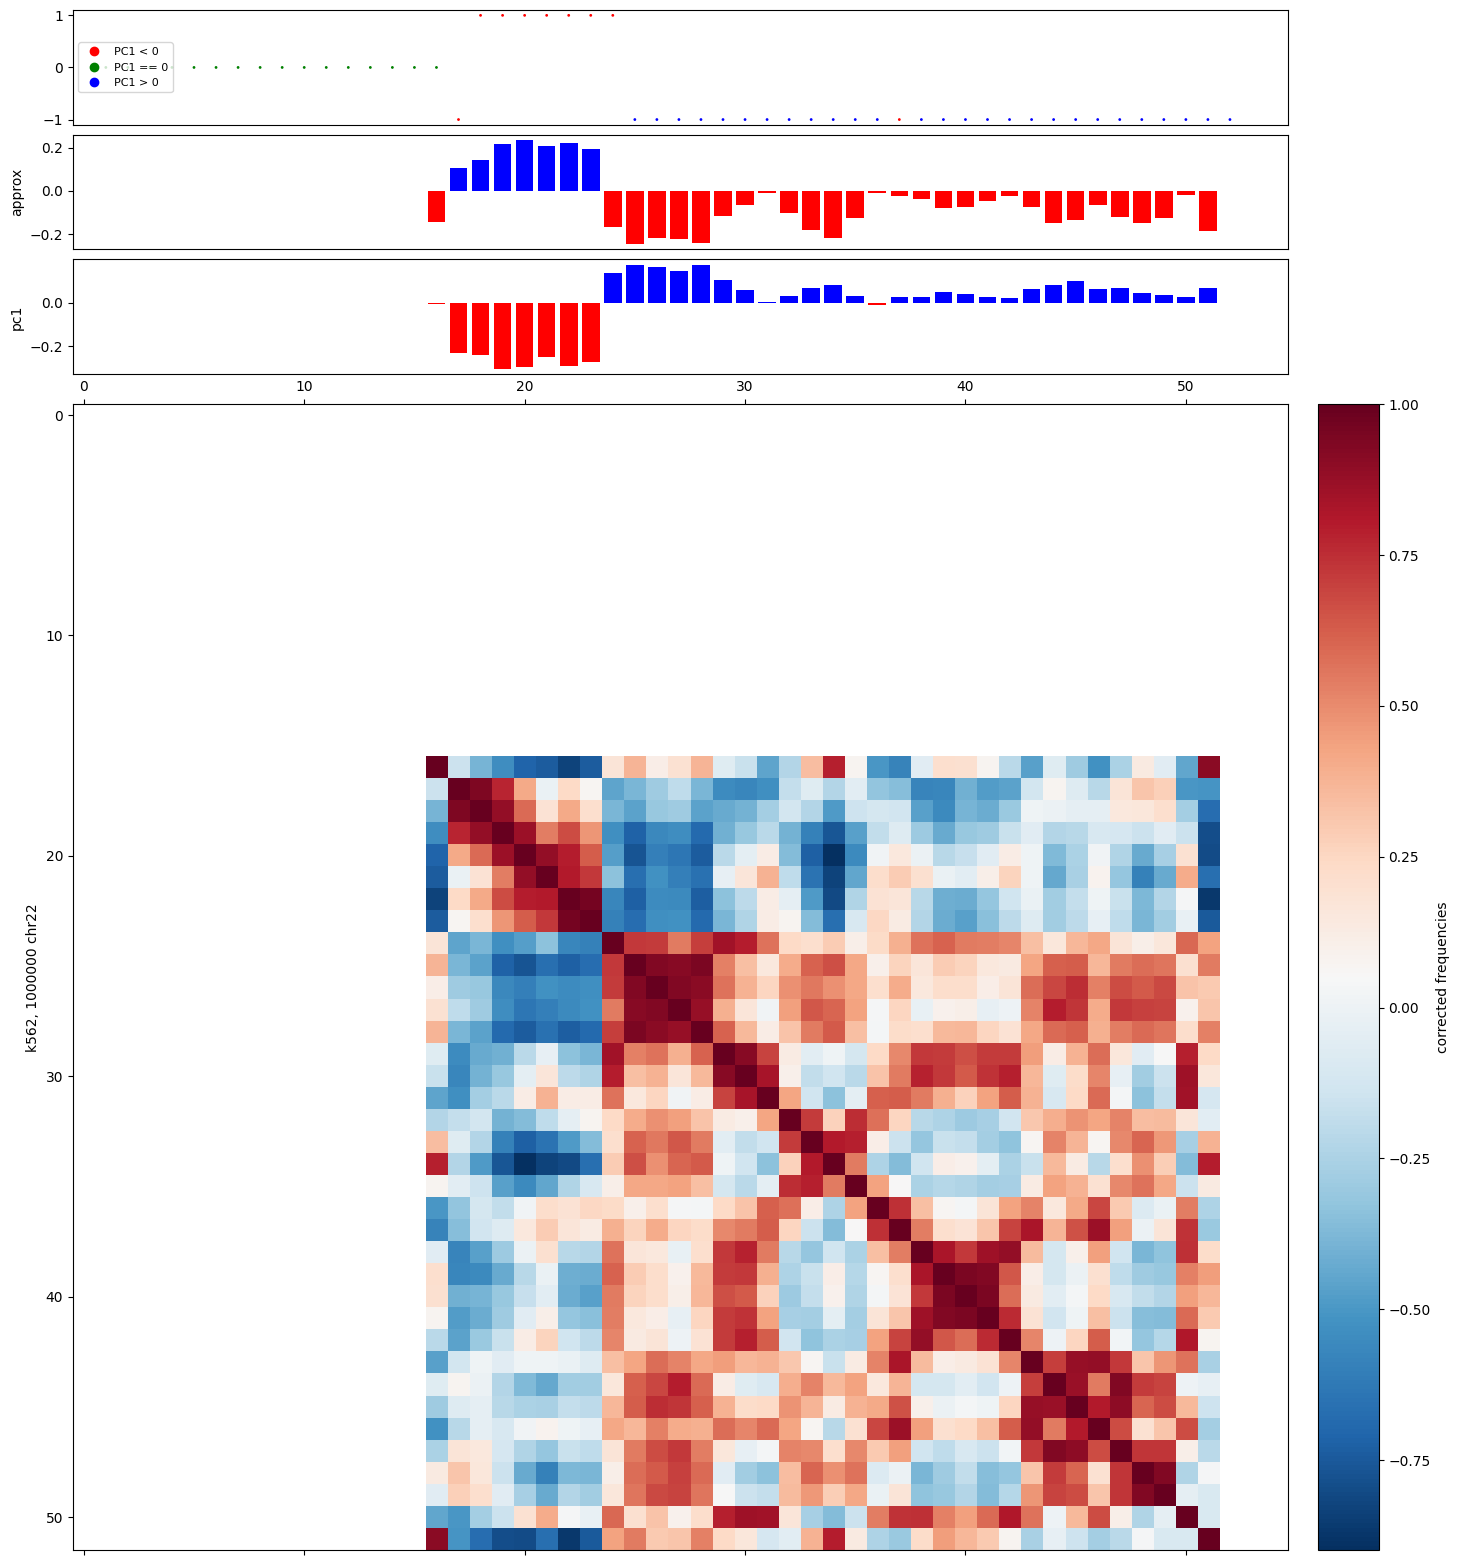

In [94]:
# Settings for pearson_np
f, ax = plt.subplots(
    figsize=(20, 20),
)
im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')

#### Settings for juicer_pc1_np
ax1 = divider.append_axes("top", size="10%", pad=0.3, sharex=ax)
juicer_pc1_x_axis = [i for i in range(0, len(juicer_pc1_np))]
juicer_pc1_bar_color = ['b' if i > 0 else 'r' for i in juicer_pc1_np]
ax1.bar(x=juicer_pc1_x_axis, height=juicer_pc1_np, color=juicer_pc1_bar_color)
ax1.set_ylabel('pc1')
ax1.xaxis.set_visible(False)

#### Settings for approx_np
ax2 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax2.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax2.set_ylabel('approx')
ax2.xaxis.set_visible(False)

#### Settings for pc1_np vs approx_np
similarity_info = paptools.calc_similarity(juicer_pc1_np, approx_np)
total_entry_num = similarity_info["total_entry_num"]
print(similarity_info)
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
juicer_pc1_colors_values = [2 if i > 0 else 0 if i < 0 else 1 for i in juicer_pc1_np]
juicer_pc1_colors = ListedColormap(['r', 'g', 'b'])
scatter_labels = ["PC1 < 0", "PC1 == 0", "PC1 > 0"]

ax3 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
scatter_config = ax3.scatter(plot_x_axis, approx_dots, c=juicer_pc1_colors_values, cmap=juicer_pc1_colors, s=1)
ax3.legend(handles=scatter_config.legend_elements()[0], labels=scatter_labels, fontsize="8", loc="center left")
ax3.xaxis.set_visible(False)

The similar_rate between the Scikit-learn calculated PC1 and juicer_tools calculated PC1.  

In [95]:
from sklearn.decomposition import PCA

pearson_np = paptools.read_pearson(pearson=pearson)
pearson_np = pearson_np.astype('float64')
diag = np.diag(pearson_np)
diag_valid = ~np.isnan(diag)
ixgrid = np.ix_(diag_valid, diag_valid) # Record the position of the valid sub-matrix.
pearson_np = pearson_np[ixgrid]

pca = PCA(n_components=1)
pca.fit(pearson_np)
# Place back the valid entries to it's origin position in the chromosome.  
pc1_np = np.full(len(diag_valid), np.nan)
pc1_np[diag_valid] = pca.components_[0]


print("Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in PC1:")
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)

print("\nShowing the mean of the GC-content at the positive sign entries versus the negative sign entries in approx_np:")
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

paptools.calc_similarity(track1_np=pc1_np, track2_np=approx_np)

Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in PC1:
Mean of the GC-content of the positive sign: 48.58571428571428
Mean of the GC-content of the negative sign: 47.8

Showing the mean of the GC-content at the positive sign entries versus the negative sign entries in approx_np:
Mean of the GC-content of the positive sign: 48.58571428571428
Mean of the GC-content of the negative sign: 47.8


{'total_entry_num': 52,
 'valid_entry_num': 36,
 'similar_num': 36,
 'similar_rate': 1.0}